# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import ExtraTreesRegressor


### Первоначальное ознакомление с данными

In [2]:
data = pd.read_csv('C:\\Users\\admin\\Desktop\\DS_yandex\\10_Определение стоимости автомобилей\\autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Отсев лишней информации

Уберем столбцы, данные которых не влияют на цену, а значит и не нужны для модели обучения.

In [5]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [6]:
data.drop(['DateCrawled', 
           'RegistrationMonth', 
           'DateCreated', 
           'NumberOfPictures', 
           'PostalCode', 
           'LastSeen'], axis = 1, inplace = True)

### Заполнение пропусков и удаление выбросов и аномалий

In [7]:
data.isna().mean()

Price               0.000000
VehicleType         0.105794
RegistrationYear    0.000000
Gearbox             0.055967
Power               0.000000
Model               0.055606
Kilometer           0.000000
FuelType            0.092827
Brand               0.000000
NotRepaired         0.200791
dtype: float64

Итак, мы имеем 10,5% пропусков в столбце "VehicleType", 5,5% - в "Gearbox", 5,5% - в "Model", 9,2% - в "FuelType", 20% - в "NotRepaired". 
Просмотрим уникальные значения столбцов датасета.

In [8]:
for i in data.columns:
    print('Уникальные значения столбца', i, ':')
    print(data[i].sort_values().unique())
    print('-----------------------------------------------------------------------')

Уникальные значения столбца Price :
[    0     1     2 ... 19998 19999 20000]
-----------------------------------------------------------------------
Уникальные значения столбца VehicleType :
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
-----------------------------------------------------------------------
Уникальные значения столбца RegistrationYear :
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 320

['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]
-----------------------------------------------------------------------
Уникальные значения столбца Brand :
['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']
-----------------------------------------------------------------------
Уникальные значения столбца NotRepaired :
['no' 'yes' nan]
-----------------------------------------------------------------------


Помимо пропусков в данных много аномально больших и малых значений, от которых мы сейчас и избавимся.

#### Столбец 'Price'

In [9]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

<AxesSubplot:xlabel='Price'>

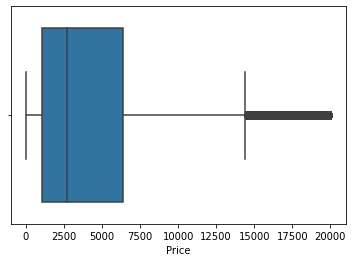

In [10]:
sns.boxplot(data['Price'])

"Нулевых" цен в датасете 10772, что составляет около 3% датасета. Избавимся от них посмотрим на гистограмму.

<AxesSubplot:>

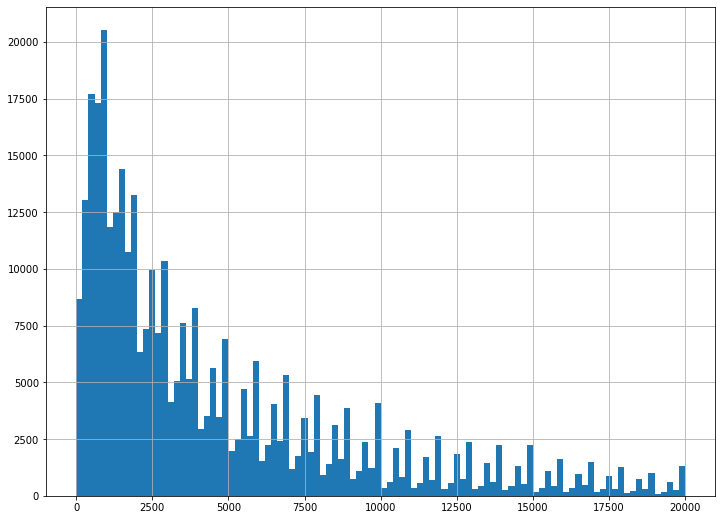

In [11]:
data = data.query('Price > 0')
data['Price'].hist(bins=100, figsize=(12,9))

Выделим квантили 5% и 90%.

In [12]:
data['Price'].quantile([.05, .90])

0.05      350.0
0.90    11500.0
Name: Price, dtype: float64

In [13]:
data = data.query('350 <= Price <= 11500')

#### Столбец 'Model'

Учитывая невозможность корректного заполнения пропусков в данном столбце и малого количества пропусков к общему количеству записей в датасете удалим строки с пропусками.

In [14]:
data = data.loc[~ data['Model'].isna()]
data['Model'].isna().sum()

0

#### Столбец 'VehicleType'

In [15]:
data['VehicleType'].isnull().sum()

23598

Пропуски в данном столбце заполним наиболее часто встречающимися средними значениями в срезе моделей.

In [16]:
def fil_na(col):
    data[col] = data[col].fillna(data.groupby('Model')[col].transform(lambda x: x.value_counts().idxmax()))

In [17]:
fil_na('VehicleType')
data['VehicleType'].isna().sum()

0

#### Столбец 'Gearbox'

In [18]:
data['Gearbox'].isnull().sum()

11615

В данном столбце пропуски заполним по тому же принципу, что и в столбце 'VehicleType'.

In [19]:
fil_na('Gearbox')
data['Gearbox'].isna().sum()

0

#### Столбец 'FuelType'

In [20]:
data['FuelType'].isnull().sum()

19435

Снова воспользуемся тем же принципом заполнения пропуском, как и в предыдущих двух случаях.

In [21]:
fil_na('FuelType')
data['FuelType'].isna().sum()

0

#### Столбец 'RegistrationYear'

In [22]:
data['RegistrationYear'].describe()

count    279462.000000
mean       2003.271715
std          52.519362
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Присутствуют как слишком малые значения(**1000**), так и слишком большие(**9999**). Чтобы отрезать слишком большие значения, обратим внимание дату самой поздней выгрузки объявлений из базы. Она датируется 2016 годом, значит максимальным значением в нашем датасете будет 2016 год. Минимальным значением в данном столбце пока установим 1886 год (год появления первого серийного автомобиля). И рассмотрим гистограмму с такими границами.

<AxesSubplot:>

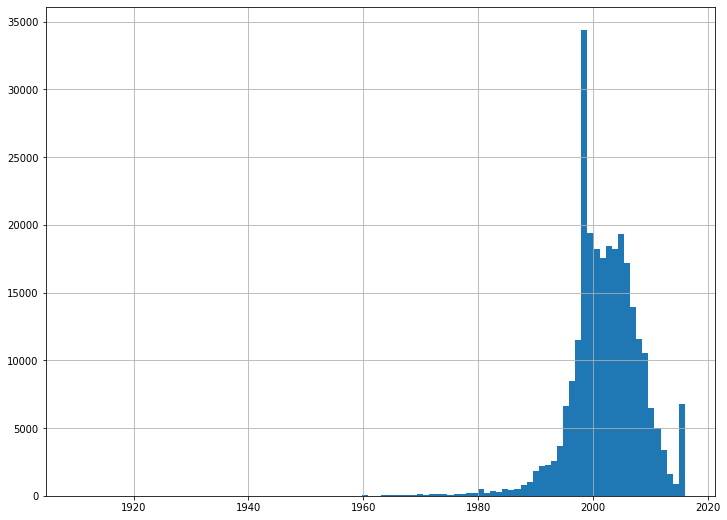

In [23]:
data = data.query('1885 < RegistrationYear < 2017')
data['RegistrationYear'].hist(bins=100, figsize=(12,9))

Приняв во внимание гистограмму ограничим минимальный год производства автомобиля 1960 годом.

In [24]:
data = data.query('RegistrationYear > 1959')
data['RegistrationYear'].describe()

count    268279.000000
mean       2002.276738
std           6.079197
min        1960.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

#### Столбец 'Power'

In [25]:
data['Power'].describe()

count    268279.000000
mean        108.328550
std         179.770983
min           0.000000
25%          72.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

<AxesSubplot:>

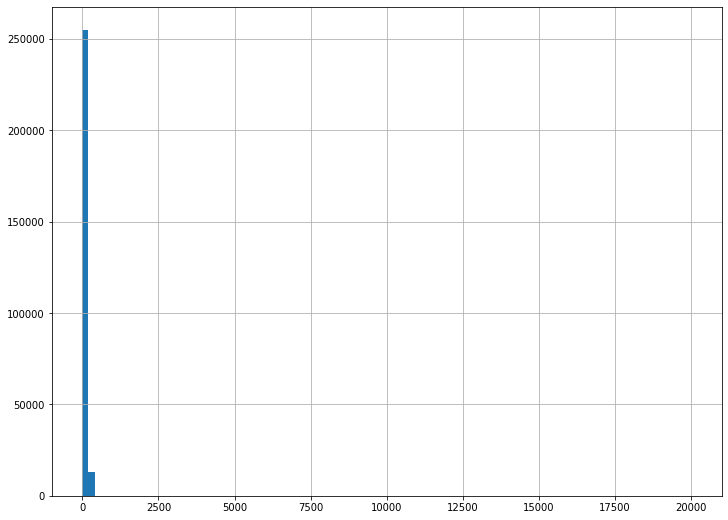

In [26]:
data['Power'].hist(bins=100, figsize=(12,9))

Уменьшим максимальную границу постороения гистограммы до 1000 л.с..

<AxesSubplot:>

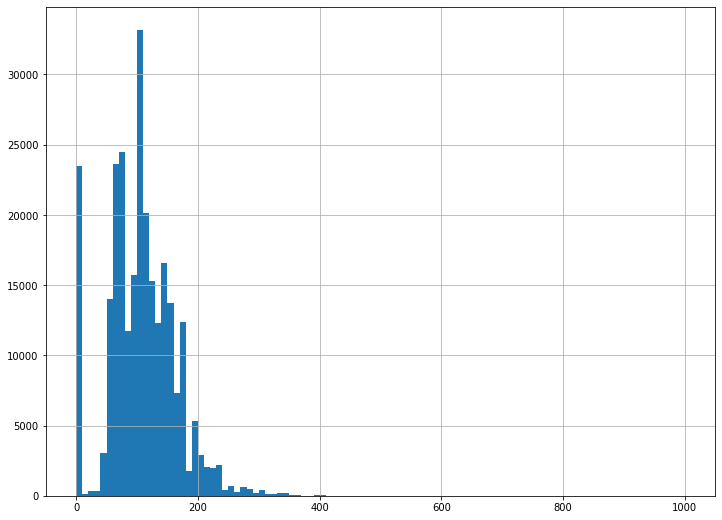

In [27]:
data['Power'].hist(bins=100, figsize=(12,9), range = (0, 1000))

Избавимся от "нулевой" мощности и отрежем значения, превышающие значение в 400 л.с..

<AxesSubplot:>

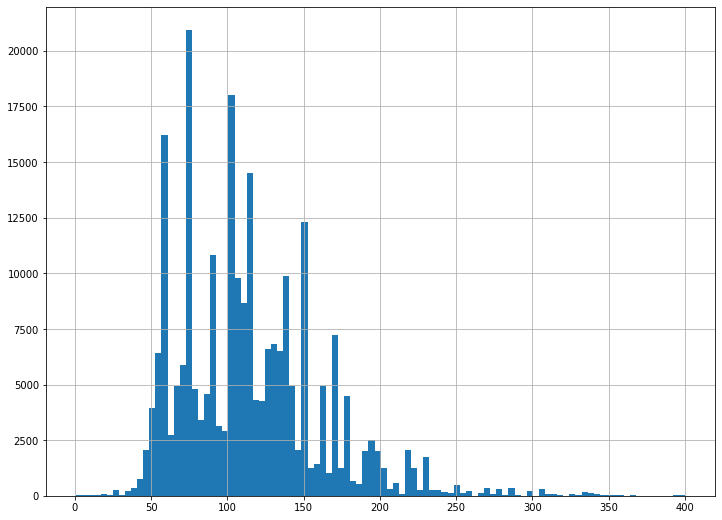

In [28]:
data = data.query('0 < Power < 401')
data['Power'].hist(bins=100, figsize=(12,9))

<AxesSubplot:>

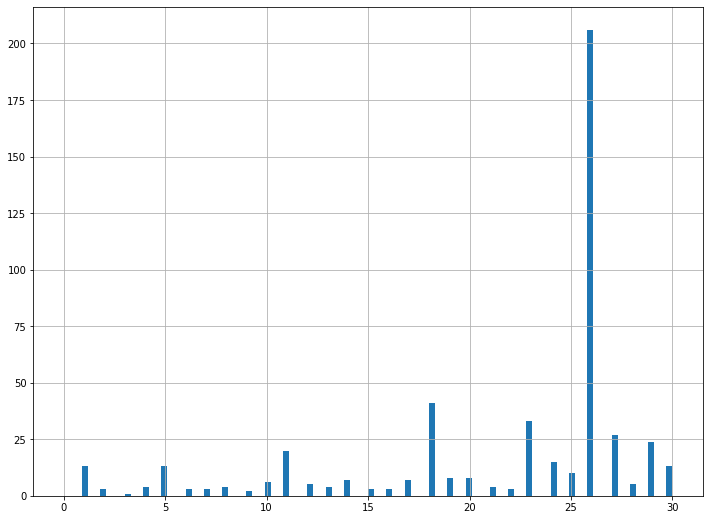

In [29]:
data['Power'].hist(bins=100, figsize=(12,9), range = (0, 30))

<AxesSubplot:>

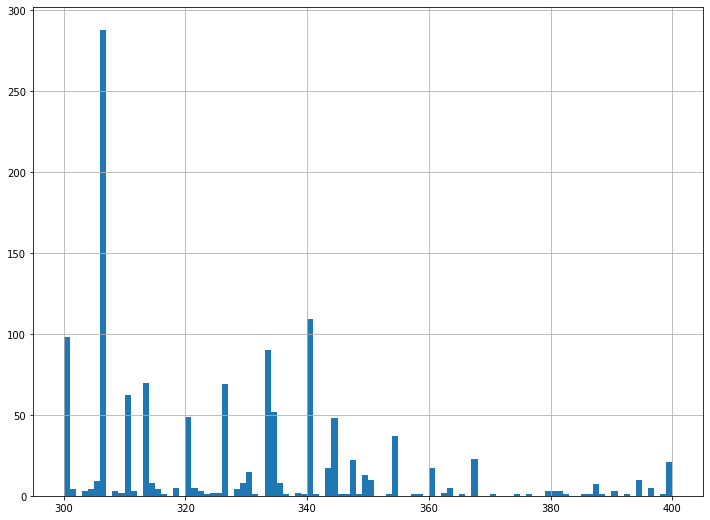

In [30]:
data['Power'].hist(bins=100, figsize=(12,9), range = (300, 400))

Ограничимся минимальным значением мощности в 25 л.с., а максимальным - 360 л.с..

In [31]:
data = data.query('24 < Power < 361')

#### Столбец 'NotRepaired'

Заменим все значения "nan" на "yes".

In [32]:
data['NotRepaired'] = data['NotRepaired'].fillna('yes')

In [33]:
data['NotRepaired'].unique()

array(['yes', 'no'], dtype=object)

### Замена значений столбцов 'Gearbox' и 'NotRepaired'

Заменим значения столбцов 'Gearbox' и 'NotRepaired' на 'IsManualGearbox' и 'IsNotRepaired' соответственно, значения в которых будут булева типа.

In [34]:
data['IsManualGearbox'] = 0
data.loc[data['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(data['IsManualGearbox'].value_counts())
data['Gearbox'].value_counts()

1    200549
0     43625
Name: IsManualGearbox, dtype: int64

manual    200549
auto       43625
Name: Gearbox, dtype: int64

In [35]:
data['IsNotRepaired'] = 0
data.loc[data['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
display(data['IsNotRepaired'].value_counts())
data['NotRepaired'].value_counts()

0    186747
1     57427
Name: IsNotRepaired, dtype: int64

no     186747
yes     57427
Name: NotRepaired, dtype: int64

Удалим 'Gearbox' и 'NotRepaired'.

In [36]:
data.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)

#### Уменьшим размерность таблицы для ускорения работы с датафреймом

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244174 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             244174 non-null  int64 
 1   VehicleType       244174 non-null  object
 2   RegistrationYear  244174 non-null  int64 
 3   Power             244174 non-null  int64 
 4   Model             244174 non-null  object
 5   Kilometer         244174 non-null  int64 
 6   FuelType          244174 non-null  object
 7   Brand             244174 non-null  object
 8   IsManualGearbox   244174 non-null  int64 
 9   IsNotRepaired     244174 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 20.5+ MB


In [38]:
for col in ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'IsNotRepaired', 'IsManualGearbox']:
    data[col] = pd.to_numeric(data[col], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244174 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             244174 non-null  int16 
 1   VehicleType       244174 non-null  object
 2   RegistrationYear  244174 non-null  int16 
 3   Power             244174 non-null  int16 
 4   Model             244174 non-null  object
 5   Kilometer         244174 non-null  int32 
 6   FuelType          244174 non-null  object
 7   Brand             244174 non-null  object
 8   IsManualGearbox   244174 non-null  int8  
 9   IsNotRepaired     244174 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 12.1+ MB


### Вывод:

Былы изучены данные. Заполнены пропуски, удалены аномальные и пропущенные значения. Отобраны небходимые столбцы для обучения модели. Заменены два категориальных признака на численные.

## Обучение моделей

Выберем следующие регрессоры для обучения модели:

1. LinearRegression;
2. DecisionTreeRegressor;
3. CatBoostRegressor;
4. LGBMRegressor.

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

### Подготовим признаки

Подготовим три типа признаков для кроссвалидации:

- Неизмененные - features;
- Закодированные методом OHE - ohe_features;
- Закодированные методом OE - ordinal_features.

In [39]:
features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=12345)

In [40]:
ohe_features = pd.get_dummies(features, drop_first=True)

ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]

In [41]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType', 'Model', 'FuelType', 'Brand']
cat_features = features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]
    
ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

### Linear Regression

In [42]:
%%time

model = LinearRegression()
cv_RMSE_LR = (cross_val_score(model, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средний показатель RMSE для кросс-валидации LinearRegression =', cv_RMSE_LR)

Средний показатель RMSE для кросс-валидации LinearRegression = 1771.1818062153911
CPU times: total: 43.5 s
Wall time: 12.5 s


In [43]:
%%time

model = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", model)])
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средний показатель RMSE для кросс-валидации LinearRegression =', cv_RMSE_LR_S)

Средний показатель RMSE для кросс-валидации LinearRegression = 7371005930546.592
CPU times: total: 48.4 s
Wall time: 17.3 s


Масштабирование ухудшает модель, применять его мы не будем.

### Decision Tree Regressor

Данную модель обучим как на OHE-закодированных данных, так и на OE-закодированных.

#### Обучение на OHE-закодированных данных

In [44]:
%%time

model = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Параметр 'max_depth' с лучшим RMSE:", clf.best_params_['max_depth'], "\n")
print("Показатель RMSE при различных значениях 'max_depth':\n")
print("   RMSE   |'max_depth'")
print("----------|-----------")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f |     %r     "% ((mean*-1)** 0.5, params['max_depth']))
        
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

Параметр 'max_depth' с лучшим RMSE: 16 

Показатель RMSE при различных значениях 'max_depth':

   RMSE   |'max_depth'
----------|-----------
2133.8069 |     2     
1962.1141 |     3     
1789.0931 |     4     
1690.9112 |     5     
1610.4809 |     6     
1546.3602 |     7     
1493.9271 |     8     
1450.4356 |     9     
1410.3091 |     10     
1381.3814 |     11     
1357.2122 |     12     
1342.0189 |     13     
1332.0877 |     14     
1328.1429 |     15     
1326.5265 |     16     
1327.8794 |     17     
1328.3102 |     18     
1329.4746 |     19     
1333.7023 |     20     
1336.7440 |     21     
1339.3759 |     22     
1346.8945 |     23     
1349.5521 |     24     
1351.7885 |     25     
1353.5176 |     26     
1354.8712 |     27     
1356.9144 |     28     
1357.0030 |     29     
1362.2768 |     30     

CPU times: total: 7min 2s
Wall time: 7min 2s


#### Обучение на OE-закодированных данных

In [45]:
%%time

model = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметр 'max_depth' с лучшим RMSE:", clf.best_params_['max_depth'], "\n")
print("Показатель RMSE при различных значениях 'max_depth':\n")
print("   RMSE   |'max_depth'")
print("----------|-----------")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f |     %r     "% ((mean*-1)** 0.5, params['max_depth']))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Параметр 'max_depth' с лучшим RMSE: 14 

Показатель RMSE при различных значениях 'max_depth':

   RMSE   |'max_depth'
----------|-----------
2133.8069 |     2     
1964.9635 |     3     
1792.1820 |     4     
1688.1704 |     5     
1601.3873 |     6     
1537.8649 |     7     
1480.9946 |     8     
1438.8638 |     9     
1401.7282 |     10     
1372.4229 |     11     
1350.3971 |     12     
1337.4160 |     13     
1330.6715 |     14     
1334.1033 |     15     
1343.7684 |     16     
1353.2993 |     17     
1364.4771 |     18     
1372.4929 |     19     
1382.9156 |     20     
1385.8042 |     21     
1387.8913 |     22     
1390.8620 |     23     
1393.9412 |     24     
1398.0297 |     25     
1399.9343 |     26     
1396.8045 |     27     
1398.3772 |     28     
1399.5687 |     29     
1398.8308 |     30     

CPU times: total: 45 s
Wall time: 45 s


### Cat Boost Regressor

Данную модель обучим как на исходных признаках(с указанием тех из них, которые являются категориальными), так и на OE-закодированных.

#### Обучение на OE-закодированных данных

In [46]:
%%time

model = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметр 'learning_rate' модели с лучшим RMSE:", clf.best_params_['learning_rate'], "\n")
print("Показатель RMSE при различных значениях 'learning_rate':\n")
print("   RMSE   |'learning_rate'")
print("----------|---------------")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f |      %r       "% ((mean*-1)** 0.5, params['learning_rate']))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

Параметр 'learning_rate' модели с лучшим RMSE: 0.5 

Показатель RMSE при различных значениях 'learning_rate':

   RMSE   |'learning_rate'
----------|---------------
1165.3554 |      0.1       
1150.7402 |      0.5       
1163.4554 |      0.8       

CPU times: total: 27min 29s
Wall time: 3min 10s


#### Обучение на исходных признаках (с указанием категориальных)

In [47]:
%%time

model = CatBoostRegressor(learning_rate = 0.5, 
                          iterations = 200,
                          random_state = 12345, 
                          verbose = False, 
                          cat_features = cat_columns) 
cv_RMSE_CBR_original = (cross_val_score(model,
                                        features_train, 
                                        target_train, 
                                        cv=5, 
                                        scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средний показатель RMSE для кросс-валидации для CatBoostRegressor =', cv_RMSE_CBR_original)

Средний показатель RMSE для кросс-валидации для CatBoostRegressor = 1177.4352578193461
CPU times: total: 5min 51s
Wall time: 1min 31s


### LGBM Regressor

In [48]:
%%time

model = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Параметры модели с лучшим RMSE: 'num_leaves' -", clf.best_params_['num_leaves'], 
      " и 'learning_rate' -", clf.best_params_['learning_rate'], "\n")
print("Показатель RMSE при различных значениях 'num_leaves' и 'learning_rate':\n")
print("   RMSE   |'learning_rate'|'num_leaves'")
print("----------|---------------|------------")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.4f |      %r      |     %r     "% ((mean*-1)** 0.5, params['learning_rate'], params['num_leaves']))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Параметры модели с лучшим RMSE: 'num_leaves' - 200  и 'learning_rate' - 0.3 

Показатель RMSE при различных значениях 'num_leaves' и 'learning_rate':

   RMSE   |'learning_rate'|'num_leaves'
----------|---------------|------------
1219.4132 |      0.1      |     31     
1166.8576 |      0.1      |     100     
1147.2796 |      0.1      |     200     
1179.6760 |      0.3      |     31     
1150.4351 |      0.3      |     100     
1144.2554 |      0.3      |     200     
1179.5259 |      0.5      |     31     
1163.2577 |      0.5      |     100     
1166.1605 |      0.5      |     200     

CPU times: total: 5min 20s
Wall time: 27.8 s


### Вывод:

Были обучены 4 модели, сохранены лучшие гиперпараметры и время обучения.

## Анализ моделей

Проведем обучение моделей с наилучшими параметрами.

### Linear Regression

In [49]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: total: 11.1 s
Wall time: 2.89 s


LinearRegression()

In [50]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: total: 656 ms
Wall time: 98.6 ms


In [51]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

### Decision Tree Regressor

#### Обучение на OHE-закодированных данных

In [52]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=16, 
                              random_state=12345) 
model.fit(ohe_features_train, target_train)

CPU times: total: 3.83 s
Wall time: 3.81 s


DecisionTreeRegressor(criterion='mse', max_depth=16, random_state=12345)

In [53]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: total: 78.1 ms
Wall time: 82 ms


In [54]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5

#### Обучение на OE-закодированных данных

In [55]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=12345) 
model.fit(ordinal_features_train, target_train)

CPU times: total: 375 ms
Wall time: 369 ms


DecisionTreeRegressor(criterion='mse', max_depth=13, random_state=12345)

In [56]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: total: 15.6 ms
Wall time: 14 ms


In [57]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

### Cat Boost Regressor

#### Обучение на OE-закодированных данных

In [58]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

CPU times: total: 2min 3s
Wall time: 14.2 s


In [59]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: total: 172 ms
Wall time: 19 ms


In [60]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

#### Обучение на исходных признаках (с указанием категориальных)

In [61]:
%%time

model = CatBoostRegressor(learning_rate = 0.5, 
                          iterations = 200, 
                          random_state = 12345, 
                          verbose = False,
                          cat_features = cat_columns) 
model.fit(features_train, target_train)

CPU times: total: 1min 30s
Wall time: 20.1 s


In [62]:
%%time

target_predict = model.predict(features_test)

CPU times: total: 234 ms
Wall time: 82 ms


In [63]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

#### LGBM Regressor

In [64]:
%%time

model = LGBMRegressor(learning_rate = 0.3, 
                      num_leaves = 200, 
                      random_state = 12345)
model.fit(ordinal_features_train, target_train)

CPU times: total: 10.3 s
Wall time: 961 ms


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [65]:
%%time

target_predict = model.predict(ordinal_features_test)

CPU times: total: 734 ms
Wall time: 68 ms


In [66]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

#### Сравнение моделей

In [67]:
index = ['LinearRegression',
         'DecisionTreeRegressor (OHE)',
         'DecisionTreeRegressor (OE)',
         'CatBoostRegressor (OE)',
         'CatBoostRegressor (без кодирования)',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[69,
                                     274,
                                     26,
                                     726,
                                     280,
                                     181],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[16.8,
                                      5.14,
                                      0.406,
                                      96,
                                      65,
                                      9.98],
        'Время предсказания модели, сек':[0.125,
                                          0.079,
                                          0.012,
                                          0.101,
                                          0.255,
                                          0.514]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])

In [68]:
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,1771.181806,69,1768.054581,16.800,0.125,0.646041,0.024167,0.096000,0.766207
DecisionTreeRegressor (OHE),1326.526527,274,1307.006484,5.140,0.079,0.862595,0.078988,0.151899,1.093482
DecisionTreeRegressor (OE),1330.671530,26,1320.741057,0.406,0.012,0.859908,1.000000,1.000000,2.859908
CatBoostRegressor (OE),1150.740207,726,1137.748898,96.000,0.101,0.994365,0.004229,0.118812,1.117406
CatBoostRegressor (без кодирования),1177.435258,280,1167.265701,65.000,0.255,0.971820,0.006246,0.047059,1.025125
LGBMRegressor,1144.255406,181,1129.982872,9.980,0.514,1.000000,0.040681,0.023346,1.064028


#### Вывод:

Проанализированы время обучения и предсказания моделей, так же получены значения RMSE на тестовых выборках.

### Итоговый вывод:

В ходе работы было выполнено:

- загружены данные и проведена предобработка;
- выполнено сравнение моделей с использованием различных наборов гиперпараметров;
- выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минимальным временем или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению.

На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.

- Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать **DecisionTreeRegressor**. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.

- Если рассматривать только оценивание точности, то в лидеры выходит **LGBMRegressor**. Следом за ним идет **CatBoostRegressor** и **DecisionTreeRegressor** занимает третье место.

- **LinearRegression** показала себя на этой задаче очень слабо.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров:

- **Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.**
- **Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.**
- **Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.**